In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Prediction of Earthquake Damage in Nepal

### EXPLORATORY DATA

Este dataset trata sobre el terremoto denominado 'Gorkha earthquacke', que sucedió en 2015 en Nepal, en concreto, lo que queremos realizar en este notebook es crear un modelo para predeccir el nivel de daño en un edificio ocasionado por un terremoto, siendo nuestro target éste daño, el cuál se divide en 3 categorías:
* 1 = Low damage
* 2 = Medium damage
* 3 = complete destruction
  
El dataset se compone de : 156359 entradas con 38 variables como veremos a continuación:

In [191]:
# CARGAMOS LOS DATOS
data = pd.read_csv('TERREMOTOS/Earthquake_train.csv')
print(data.info())
data.head()

# Buscamos si tenemos algun tipo de valores nulos
print(f'Número de nulos = {data.isnull().sum().max()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156360 entries, 0 to 156359
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             156360 non-null  int64 
 1   geo_level_1_id                          156360 non-null  int64 
 2   geo_level_2_id                          156360 non-null  int64 
 3   geo_level_3_id                          156360 non-null  int64 
 4   count_floors_pre_eq                     156360 non-null  int64 
 5   age                                     156360 non-null  int64 
 6   area_percentage                         156360 non-null  int64 
 7   height_percentage                       156360 non-null  int64 
 8   land_surface_condition                  156360 non-null  object
 9   foundation_type                         156360 non-null  object
 10  roof_type                               156360 non-null 

Observamos que tenemos 7 columnas con valores en string, y todas las demás en formato integer, siendo algunas de ellas binarias.


Creamos un heatmap para ver cómo se relacionan las variables

In [192]:
data.set_index('building_id',inplace=True)

<AxesSubplot:>

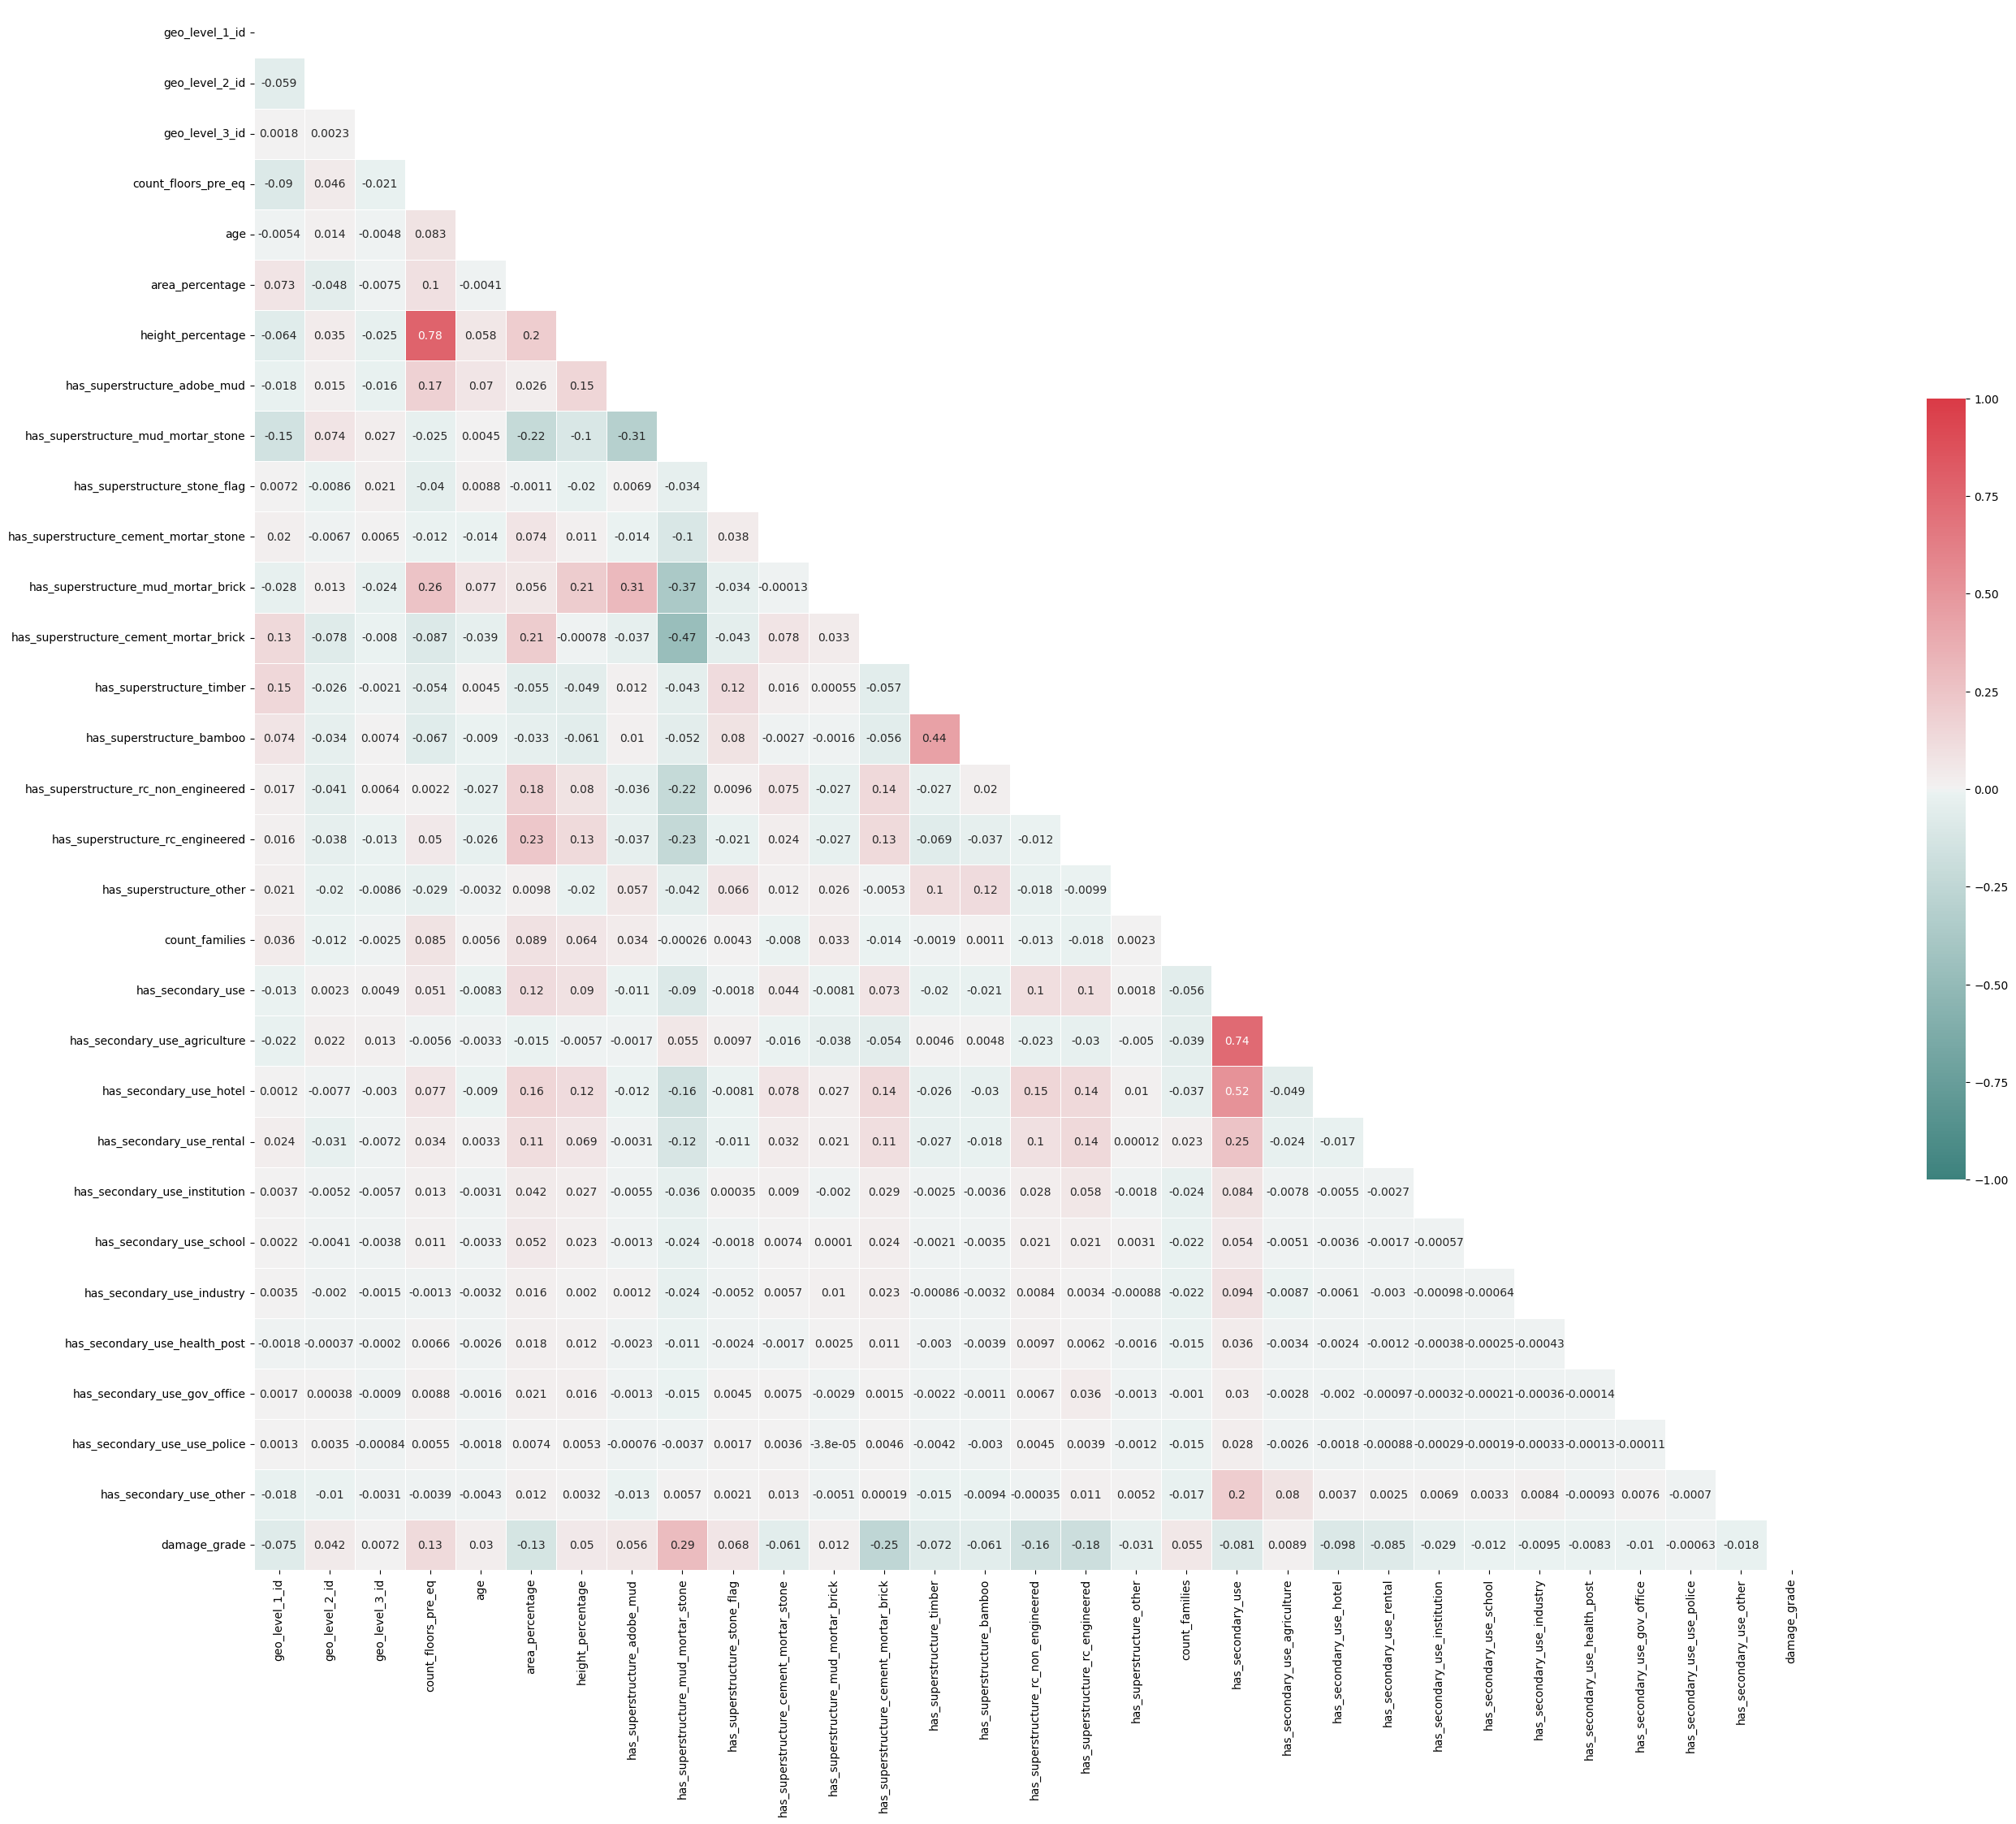

In [193]:
# CREAMOS UN MAPA DE CORRELACION PARA TENER UNA  INFORMACION GENERAL DE LOS DATOS
corr = data.corr()

# En esta ocasión lo generaremos en formato triangular aplicandole la siguiente máscara
triang = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(35,25))

#Creamos un rango de colores para mostrar 
cmap = sns.diverging_palette(185,10, as_cmap = True)

sns.heatmap(corr, mask=triang, cmap=cmap,vmin=-1, vmax=1, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)


Observamos que la relación de las variables con el target son débiles, la correlación más alta, tanto negativa como positiva, no supera el 0.3.
También podemos ver que existen dos variables altamente relacionadas, superando el .70, éstas variables son: 
* has_secondary_use | has_secondary_use_agriculture. No es extraño que éstas dos variables esten altamente correlacionadas, ya que pertenecen a la misma familia, quizas ésta alta correlación con la agricultura, sea que el uso secundario que puede tener un edificio en su mayoría sea de uso de agricultura

* Height percentage | count_floors_pre_eq. También es obvio que estén correlacionadas, ya que 'height_percentage' se refiere a la huella que tiene el edificio en altura, y count_floors_pre_eq se refiere al numero de plantas que tiene el edificio, esto es, a mayor número de plantas, mayor será su huella de altura.


A continuación observaremos la composición de nuestro target

In [11]:
# OBSERVAMOS LA COMPOSICIÓN DE NUESTRO TARGET
print(data['damage_grade'].value_counts())

# CREAMOS UNA VARIABLE NOMBRANDO LAS CATEGORIAS PARA PODER MOSTRARLAS VISUALMENTE

data['damage_label'] = data.damage_grade.map(
    {1:'Daño bajo', 2:'Daño medio', 3:'Totalmente destruido'})

2    88713
3    52519
1    15128
Name: damage_grade, dtype: int64


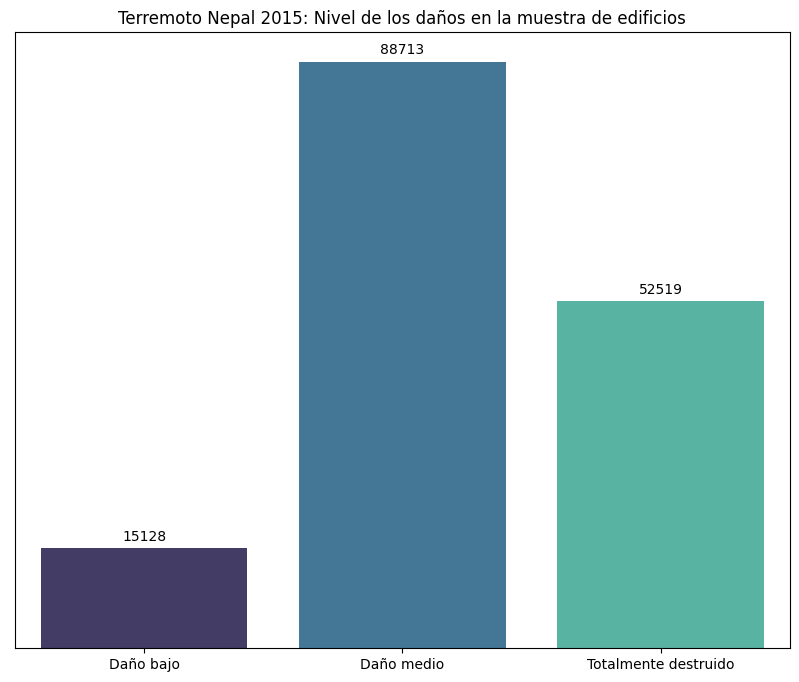

In [30]:
# REPRESENTAMOS EL NUMERO DE EDIFICIOS TOTALES POR CADA CATEGORIA DEL TARGET

# Creamos la figura dando el orden de presentación
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='damage_label', data=data, palette='mako', 
                   order=['Daño bajo', 'Daño medio', 'Totalmente destruido'])

# Añadimps los valores a cada barra del gráfico para que nos la muestre en el top
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 1115,
            '{:1.0f}'.format(height), ha="center")                   
ax.set_xlabel('')
ax.set_ylabel('Número de edificios')
ax.set_title('Terremoto Nepal 2015: Nivel de los daños en la muestra de edificios')
ax.tick_params(labelbottom=True)
ax.get_yaxis().set_visible(False)


Parece que nuestro target está bastante desbalanceado, cayendo todo el peso en el nivel de Daño medio, seguido por la destrucción total del mismo, y teniendo una proporción de daño bajo, muy pequeña en comparación.
Al tener nuestro target desbalanceado, puede implicar que en las predicciones pierda información y nos de valores no deseados debido a al target desbalanceado.

Graficamos el nivel de daño dependiendo de las condiciones del suelo, tenemos 3 formas:
* En plano
* En pendiente moderada
* En pendiente acusada

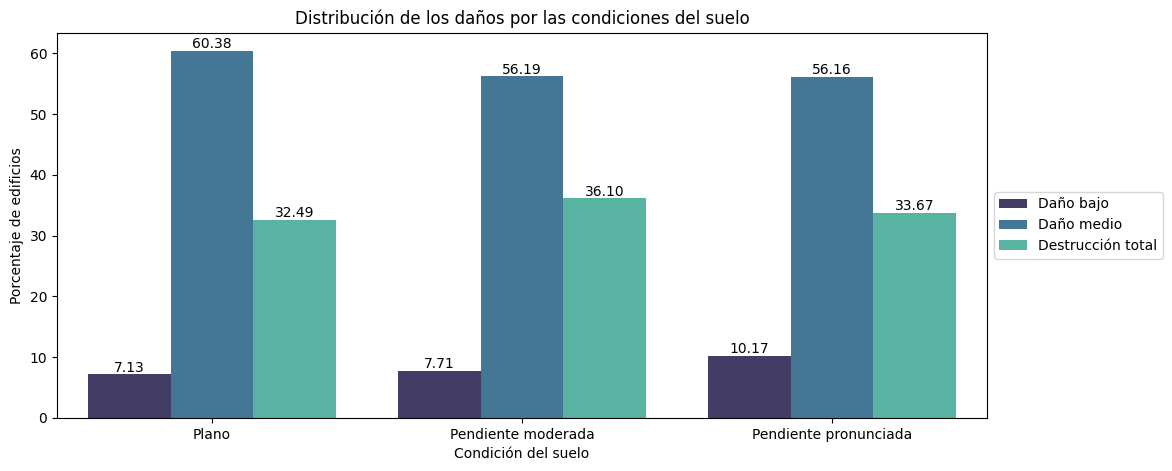

In [45]:
# AHORA OBSERVAMOS EL NIVEL DE LOS DAÑOS DEPENDIENDO DE LAS CONDICIONES DEL SUELO

surface_damage = data.groupby(['land_surface_condition','damage_grade']).size().reset_index(name='count')
surface_damage = surface_damage.set_index(['land_surface_condition', 'damage_grade'])

# Creamos los %'s
surface_damage = surface_damage.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize=(12,5))
ax = sns.barplot(data = surface_damage, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade',
                palette='mako')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.5,
            '{:.2f}'.format(height), ha="center")   

#Cambiamos el nombre de las variables X           
ax.set_xticklabels(["Plano", "Pendiente moderada", "Pendiente pronunciada"])

# Cambiamos el nombre de las variables de la leyenda
handles, labels = ax.get_legend_handles_labels()
labels = ["Daño bajo", "Daño medio", "Destrucción total"]

ax.legend(handles,labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribución de los daños por las condiciones del suelo")
plt.xlabel("Condición del suelo")
plt.ylabel("Porcentaje de edificios")
plt.show()


Parece que no hay ninguna información relevante respecto al daño en función del suelo, podría intuirse a priori que, a mayor desnive del suelo, es decir a medida que la pendiente se vuelve más acusada, el nivel de los daños serían mayores, pero parece ser que no ocurre y está equilibrado entre las tres categorías.

Ahora veamos como se distribuye el daño en función de la edad del edificio, aquí podemos pensar dos cosas que puede ocurrir:
* Los edificios más nuevos pueden llevar alguna mejora respecto a los más antiguos, en el sentido de que se han tomado medidas más innovadoras para hacer frente a catástrofes, mejores materiales de construcción, etc..., lo que llevaría a que presenten menor daño que los edificios más antiguos
* Los edificios más nuevos presentan mayores niveles de daños debido a que el nivel de población aumenta lo que hace que las construcciones se realicen de forma masiva y rápda, además, los materiales son más económicos respecto a los mas antiguos.

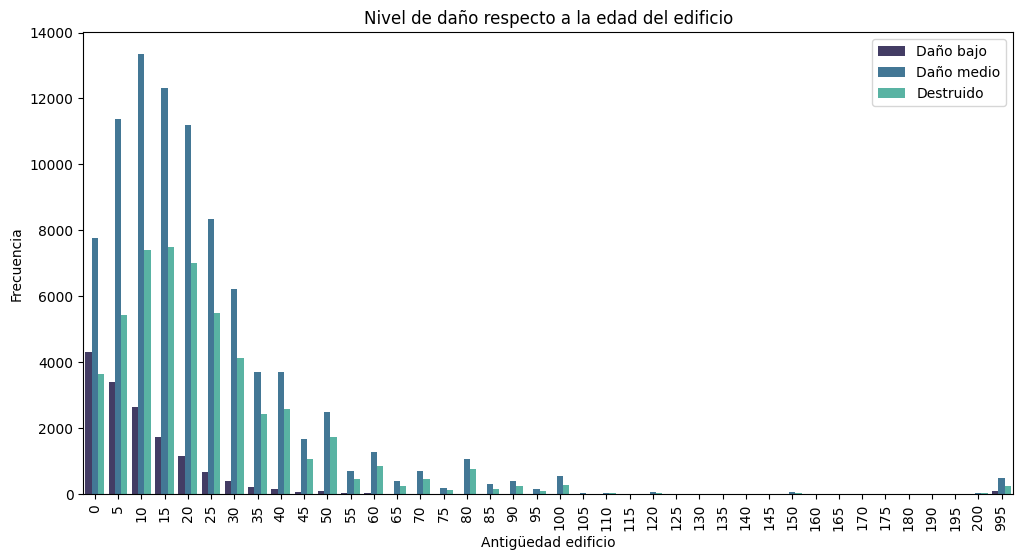

In [160]:
plt.figure(figsize=(12,6))
sns.countplot(x=data["age"],hue=data["damage_grade"],palette='mako')
plt.ylabel("Frecuencia")
plt.xlabel("Antigüedad edificio")
plt.xticks(rotation=90)
plt.title("Nivel de daño respecto a la edad del edificio")
plt.legend(["Daño bajo","Daño medio","Destruido"])
plt.show()

Pues lo que vemos, podríamos decir que los edificios más nuevos presentan una peor infraestructura que los más antiguos, también ha de mencionarse que los edificios más antiguos como los que vemos con año de 995, son edificios que se consideren sagrados o emblemáticos, lo que llevaría a que tendrán un mantenimiento continuo y cuidado.







Ahora presentaremos el daño respecto a la altura de los edificios, tanto por número de plantas como por huella en altura del edificio.

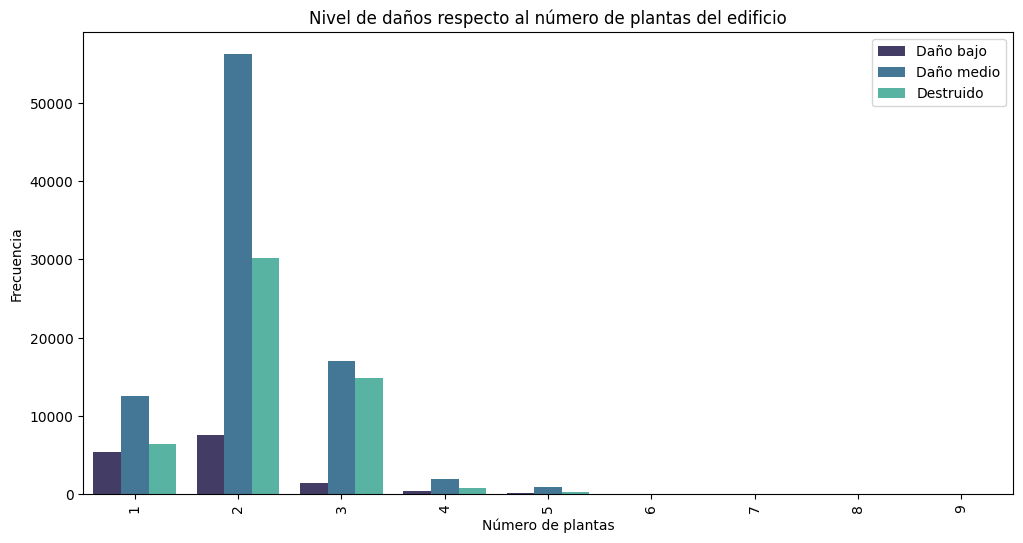

In [178]:
plt.figure(figsize=(12,6))
sns.countplot(x=data["count_floors_pre_eq"],hue=data["damage_grade"],palette='mako')
plt.ylabel("Frecuencia")
plt.xlabel("Número de plantas")
plt.xticks(rotation=90)
plt.title("Nivel de daños respecto al número de plantas del edificio")
plt.legend(["Daño bajo","Daño medio","Destruido"])
plt.show()

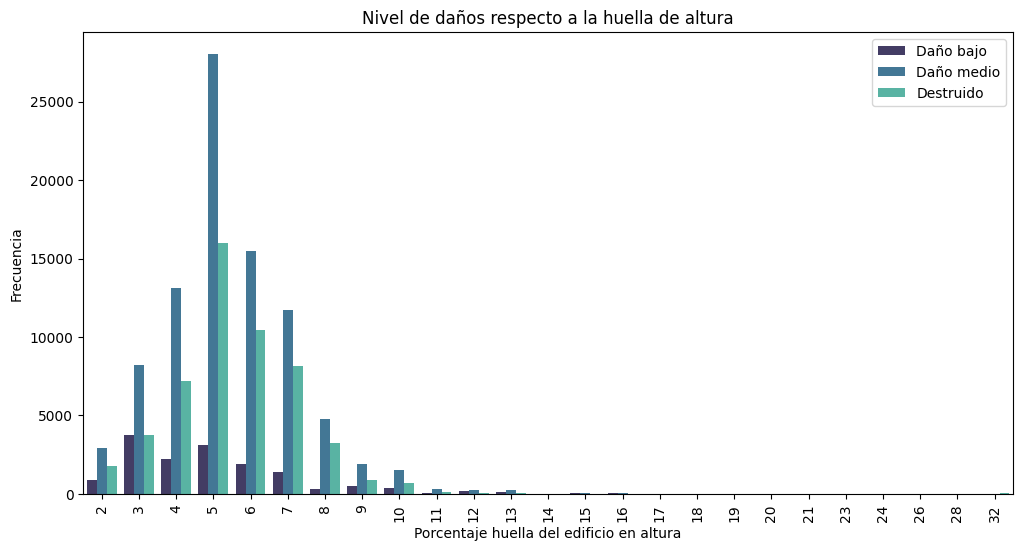

In [180]:
plt.figure(figsize=(12,6))
sns.countplot(x=data["height_percentage"],hue=data["damage_grade"],palette='mako')
plt.ylabel("Frecuencia")
plt.xlabel("Porcentaje huella del edificio en altura")
plt.xticks(rotation=90)
plt.title("Nivel de daños respecto a la huella de altura")
plt.legend(["Daño bajo","Daño medio","Destruido"])
plt.show()

Observamos que el daño se concentra en aquellos edificios de 2 a 3 plantas.


In [181]:
# Ahora separamos las columnas por su tipo
# Empezamos con las columnas binarias que son todas aquellas que empiezan por has_ y el tipo de material
binary_cols = []
for col in data.columns:
    if col.startswith('has'):
        binary_cols.append(col)

# Ahora las columnas categoricas de tipo object
cat_cols = list(data.select_dtypes(include='object').columns)
cat_cols.remove('damage_label')

# y las columnas de la geolocalizacion 
geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']


In [42]:
# mostramos las columnas binarias, correspondientes a los tipos de materiales utilizados
data[binary_cols]

,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156355,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156356,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156357,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
156358,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Tracemos el valor promedio de cada columna binaria para tener una idea de la frecuencia con la que estas características se marcan como '1', es decir, que ocurren.

c:\Users\maria\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


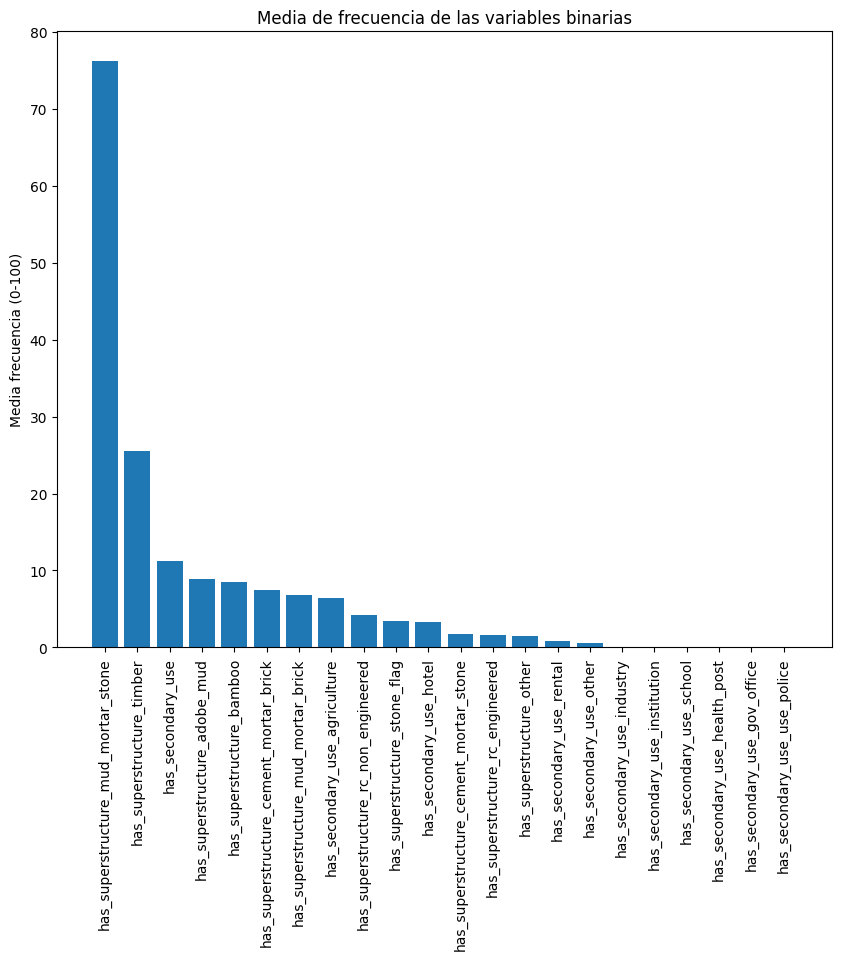

In [108]:
mean_binary_cols = data[binary_cols].mean().sort_values(ascending=False)*100
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(mean_binary_cols.index, mean_binary_cols.values)
 
ax.set_xticklabels(list(mean_binary_cols.index), rotation=90)
ax.set_ylabel('Media frecuencia (0-100)')
ax.set_title('Media de frecuencia de las variables binarias');

Todas menos tres de las columnas tienen valores promedio inferiores a 10, lo que indica que ocurren con poca frecuencia. 'has_superstructure_mud_mortar_stone', sin embargo, ocurre más del 70% del tiempo

Ahora mostramos los niveles de daños respecto a la geolocalización de nivel 1, que se refiere a la localización geográfica más generalizada

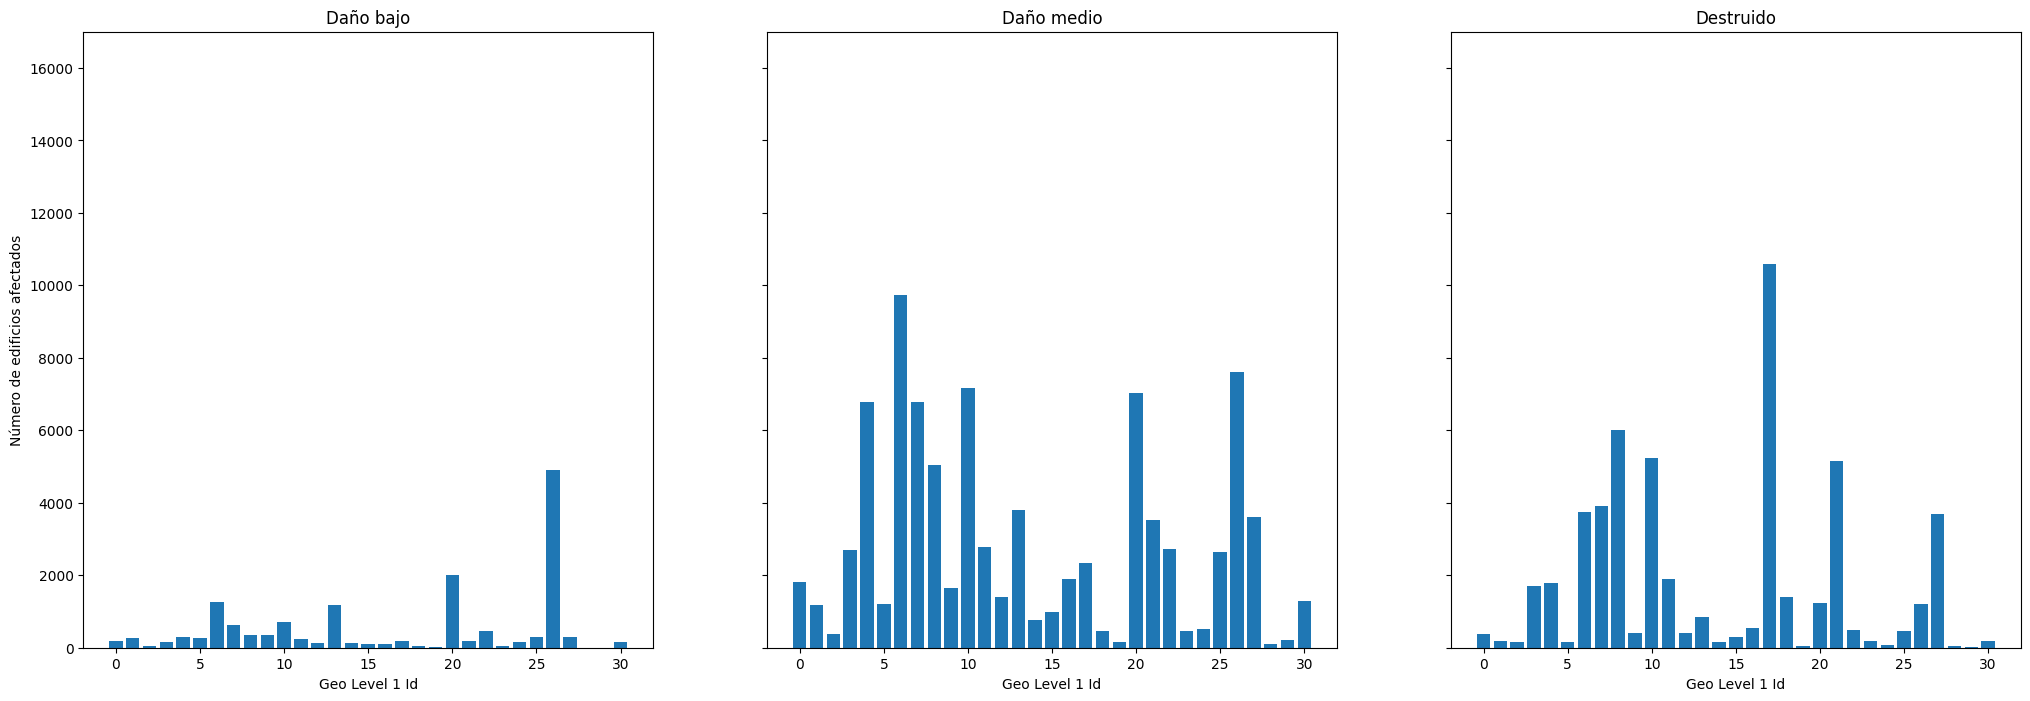

In [100]:
# Presentamos la localizacion mas cercana del epicentro divida por los niveles de daño para ver como se distribuye
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25,8), sharex=True, sharey=True)
ax1.set_title("Daño bajo")
ax1.set_xlabel("Geo Level 1 Id")
ax1.set_ylabel("Número de edificios afectados")
ax1.set_ylim(top = 17000)
ax1.bar(data[data['damage_grade'] == 1]['geo_level_1_id'].value_counts().index, data[data['damage_grade'] == 1]['geo_level_1_id'].value_counts().values,)

ax2.set_title("Daño medio")
ax2.set_xlabel("Geo Level 1 Id")
ax2.bar(data[data['damage_grade'] == 2]['geo_level_1_id'].value_counts().index, data[data['damage_grade'] == 2]['geo_level_1_id'].value_counts().values)

ax3.set_title("Destruido")
ax3.set_xlabel("Geo Level 1 Id")
ax3.bar(data[data['damage_grade'] == 3]['geo_level_1_id'].value_counts().index, data[data['damage_grade'] == 3]['geo_level_1_id'].value_counts().values)

plt.show()

El daño medio de los edificios en esta zona es significativo, seguido de la destrucción del edificio, al ser la localización más general, acogerá el mayor volumen de los edificios respecto a los siguientes niveles, que se refieren a subregiones. 


Observemos como se distribuye en el nivel 2

<BarContainer object of 1279 artists>

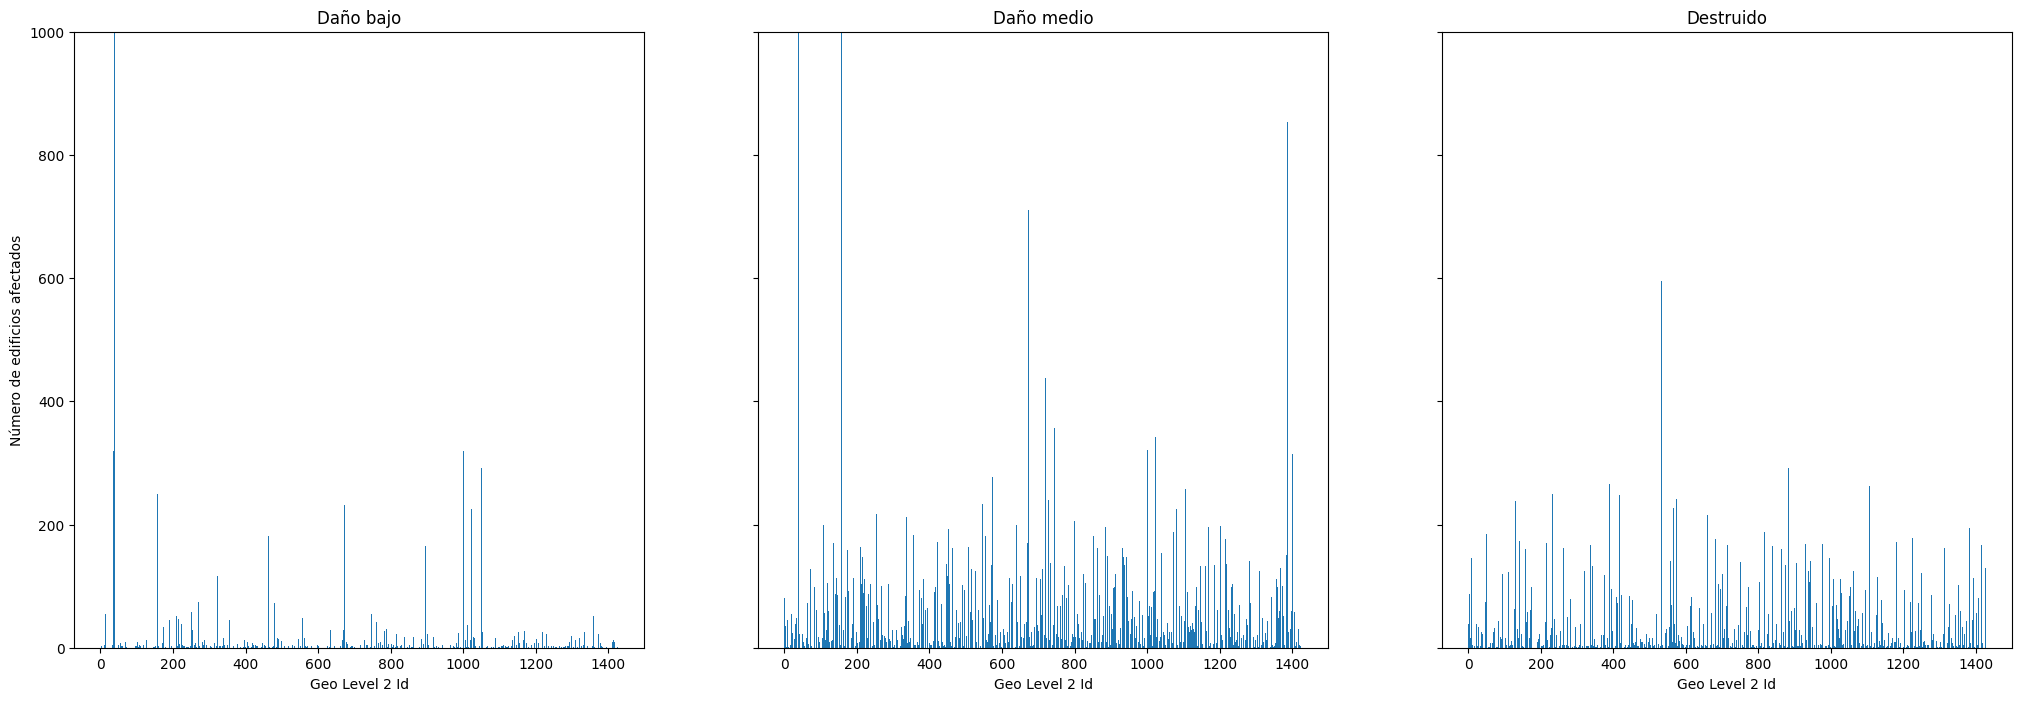

In [182]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25,8), sharex=True, sharey=True)

ax1.set_title("Daño bajo")
ax1.set_xlabel("Geo Level 2 Id")
ax1.set_ylabel("Número de edificios afectados")
ax1.set_ylim(top = 1000)
ax1.bar(data[data['damage_grade'] == 1]['geo_level_2_id'].value_counts().index, 
            data[data['damage_grade'] == 1]['geo_level_2_id'].value_counts().values)

ax2.set_title("Daño medio")
ax2.set_xlabel("Geo Level 2 Id")
ax2.bar(data[data['damage_grade'] == 2]['geo_level_2_id'].value_counts().index, 
            data[data['damage_grade'] == 2]['geo_level_2_id'].value_counts().values)

ax3.set_title("Destruido")
ax3.set_xlabel("Geo Level 2 Id")
ax3.bar(data[data['damage_grade'] == 3]['geo_level_2_id'].value_counts().index, 
            data[data['damage_grade'] == 3]['geo_level_2_id'].value_counts().values)

Observamos que también se concentran en los daños de nivel 2 y 3, pero ha de mencionarse que el ratio no lo comparte con la geolocalización 1, si observamos el eje Y, vemos que aquí tiene un tamaño hasta 1000, mientras la localizacion anterior tenía un rango de 16000, aún así, parece que hay relevancia en cuanto al nivel de daño 2 y 3, mientras en el daño de nivel bajo no tendría significancia.


Ya hemos visto de forma general las variables de este dataset, pero una de las causas, y me atrevería a decir que la más importante, es el tipo de material con la que están construidos esos edificios, y ver qué relevancia puede tener a la hora de predecirnos el nivel de daño, así como observar también posibles estrategias para llevar a cabo, dependiendo del material que presente un menor daño en su estructura, frente al material que presente mayor daño.

In [103]:
# De los datos binarios que habiamos separado anteriormente, cogemos aquellos que pertenecen al tipo de material, que empieza por "has_superstructure"
superstructure_cols = [col for col in binary_cols if col.startswith('has_superstructure')]
superstructure_cols


['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other']

Ahora queremos observar qué relacion guardan éstas superstructures respecto a los niveles de daño en el edificio

In [104]:
# CREAMOS UN DF VACÍO CON 4 COLUMNAS
df_superstructure = pd.DataFrame(columns=['superstructure', 'Low Damage', 'Medium Damage', 'Complete Destruction'])

#INICIALIZAMOS EL CONTEO A 0 Y AHORA EMPEZAMOS A ITERAR SOBRE LA LISTA DONDE ESTABAN LOS NOMBRES DE LAS COLUMNAS DE SUPERSTRUCTURE
count = 0
for col in superstructure_cols:
    # COGEMOS SOLO AQUELLOS VALORES QUE SON IGUAL A 1, ES DECIR, QUE OCURRE
    df1 = data[data[col] == 1]
    #Se cuenta el número de filas del subconjunto anterior que toman valores del 1 al 3
    # 'damage_grade', y se asignan a las variables num_1, num_2, y num_3.
    num_1 = len(df1[df1['damage_grade'] == 1])
    num_2 = len(df1[df1['damage_grade'] == 2])
    num_3 = len(df1[df1['damage_grade'] == 3])
    df_superstructure.loc[count, 'superstructure'] = col
    # Se calcula el porcentaje de filas del subconjunto que tienen el valor 1, 2 o 3
    #  y se asigna a las columnas correspondientes
    df_superstructure.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_superstructure.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_superstructure.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

In [105]:
df_superstructure.sort_values(by='Complete Destruction', ascending=False, inplace=True)

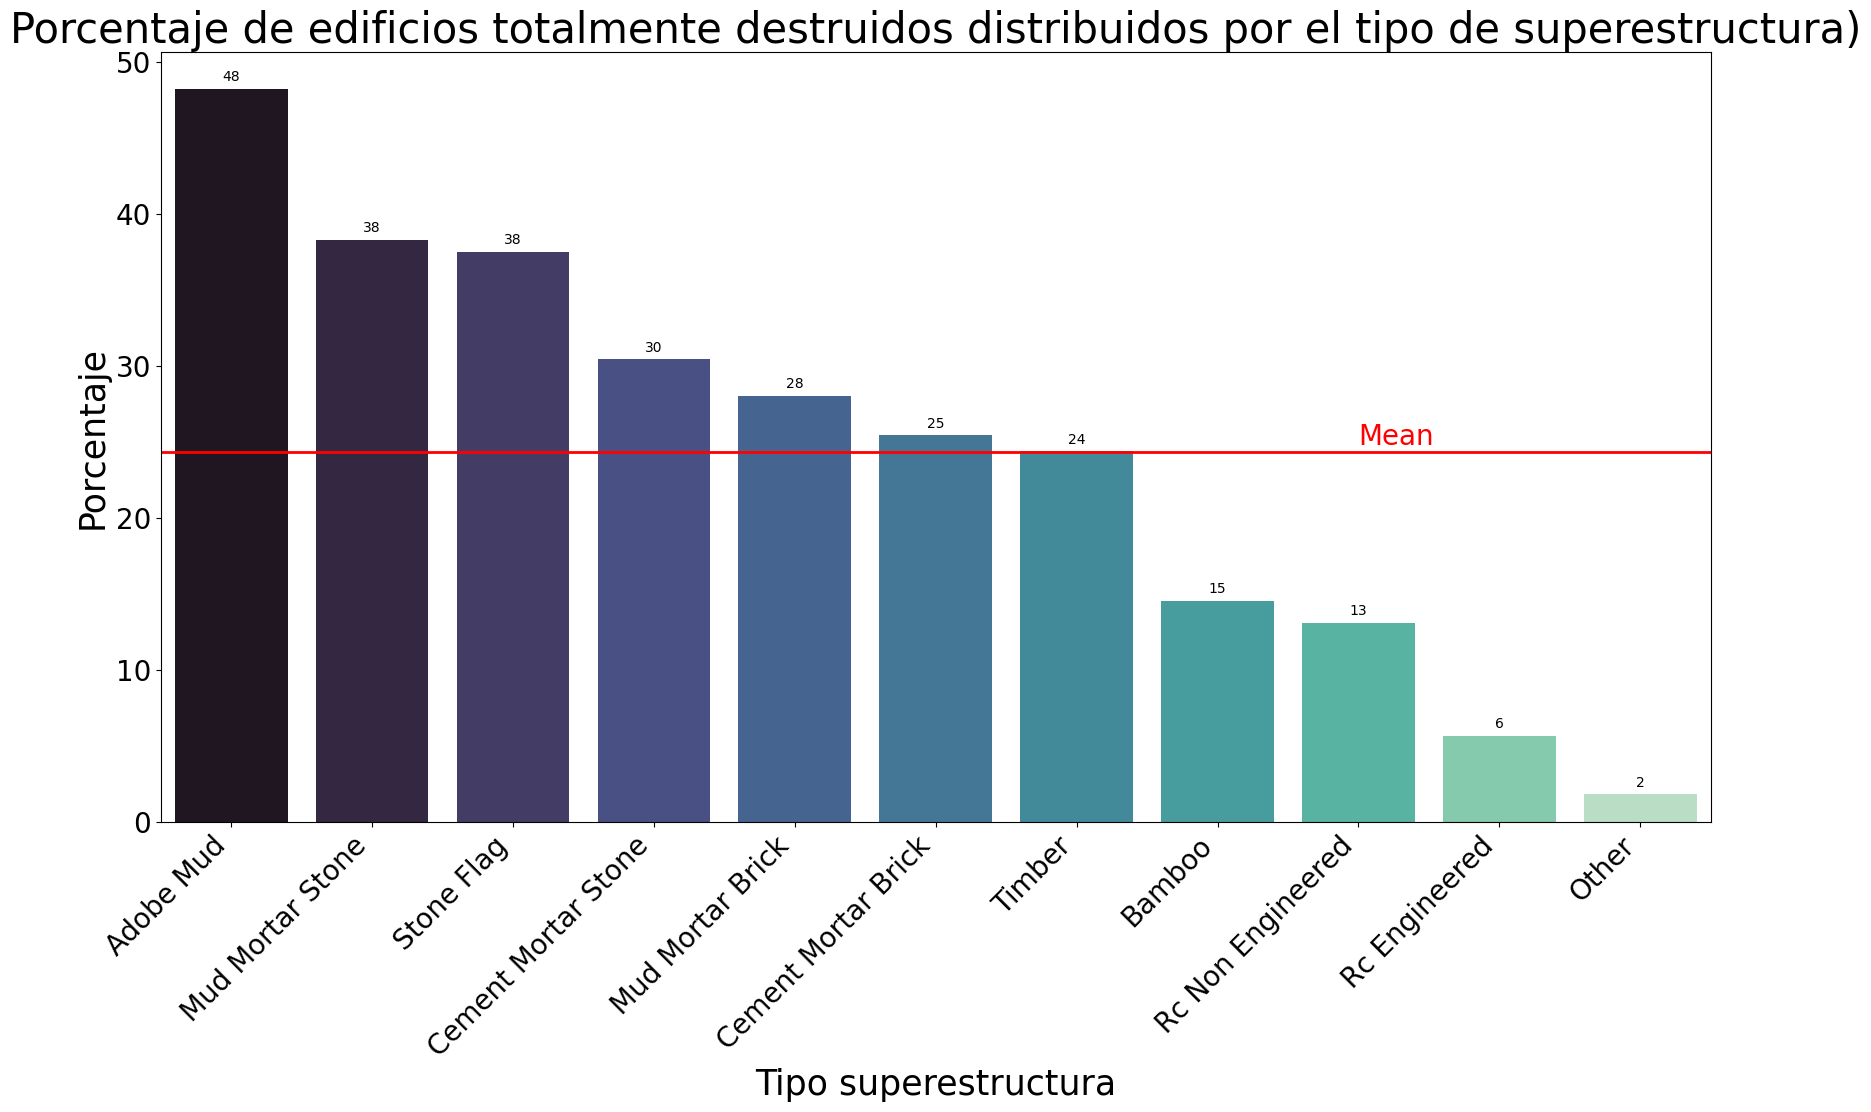

In [109]:

mean = df_superstructure['Complete Destruction'].mean()
formatted_list = []
# iteramos sobre las labels para quitar el formato indeseado 
for i, superstructure in enumerate(list(df_superstructure.superstructure)):
    formatted_string = ' '.join(df_superstructure.superstructure[i].split('_')[2:]).title()
    formatted_list.append(formatted_string)
# una vez que tenemos las labels limpias, procedemos a representarlo   
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='superstructure', y='Complete Destruction', data=df_superstructure, 
            palette='mako', ax=ax)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.5,
            '{:1.0f}'.format(height), ha="center")            
ax.axhline(mean, color='red', linewidth=2)  
ax.text(8, mean + 0.5, 'Mean', fontsize=20, color= 'r')

ax.set_ylabel('Porcentaje', fontsize=25)
plt.yticks(fontsize=20)
ax.set_xlabel('Tipo superestructura', fontsize=25)
ax.set_xticklabels(formatted_list, rotation=45, ha='right', fontsize=20)
ax.set_title('Porcentaje de edificios totalmente destruidos distribuidos por el tipo de superestructura', fontsize=30);

Los materiales que sufren mayor daño, por encima de la media son:
* "Adobe mud" = se trata de una mezcla de arena, arcilla y agua que se seca para formar ladrillos. Este material es bastante barato y muy fácil de utilizar, por ello es también que presenta el mayor número de construcciones. El problema de este material, como se puede observar en la gráfica, es que no tiene resistencia a terremotos, es un material que con vibraciones excesivas, como es el caso, comienza a agrietarse y romperse, tendiendo al derrumbe.


* "Mud Mortar Stone" = material compuesto como el anterior, que se utiliza para rellenar los huecos entre los ladrillos para una estructura más sólida, sin embargo sigue presentando el mismo problema que el mud mortar frente a los terremotos.


* "Stone flag" = compuesto de piedra natural, normalmente piedra caliza o granito. Es un material bastante resistente, pero es costoso y requiere mantenimiento. Puede ser adecuado para zonas sísmica pero, hay que tener en cuenta que siga el protocolo de construcción para el mismo, así como un nivel de mantenimiento adecuado. Aquí podría ser que no han llevado a cabo mantenimiento del edificio, o el material es de poca calidad, también entran factores como las condiciones del suelo, etc.


* "Cement Mortar Stone" = es una mezcla de cemento, arena y agua que se utiliza para unir bloques o ladrillos. Presenta las mismas características que Stone Flag, es resistente pero requiere de mantenimiento adecuado.


* "Mud Mortar Brick" = Se trata de una mezcla de arcilla, arena y agua que se utiliza como mortero para unir ladrillos de adobe, para formar una estructura estable, es barato y sencillo, y tenemos de nuevo el problema que presenta el Adobe mud frente a los terremotos.


Por otro lado, cabe mencionar aquellos materiales que ofrecen mejor resistencia, como puede ser:
* "RC Engineered" = el término RC hace referencia a elementos de refuerzo de acero, para darle una mayor consistencia y estabilidad a la estructura, son bastante resistentes y además presenta buena estructura para zonas de actividad sísimica, además el término Engineered significa que utiliza ingeniería para mejorar la seguridad y durabilidad, es una buena opción de material de construcción para el problema de este trabajo.


In [112]:
# Hacemos lo mismo que en el paso anterior, pero esta vez con las variables que representan el tipo de uso del edificio, que empiezan por has_secondary
secondary_cols = [col for col in binary_cols if col.startswith('has_secondary')]
secondary_cols.remove('has_secondary_use')

In [114]:
df_secondary = pd.DataFrame(columns=['secondary_use', 'Low Damage', 'Medium Damage', 'Complete Destruction'])

count = 0
for col in secondary_cols:
    df1 = data[data[col] == 1]
    num_1 = len(df1[df1['damage_grade'] == 1])
    num_2 = len(df1[df1['damage_grade'] == 2])
    num_3 = len(df1[df1['damage_grade'] == 3])
    df_secondary.loc[count, 'secondary_use'] = col
    df_secondary.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_secondary.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_secondary.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1
df_secondary.sort_values(by='Complete Destruction', ascending=False, inplace=True)


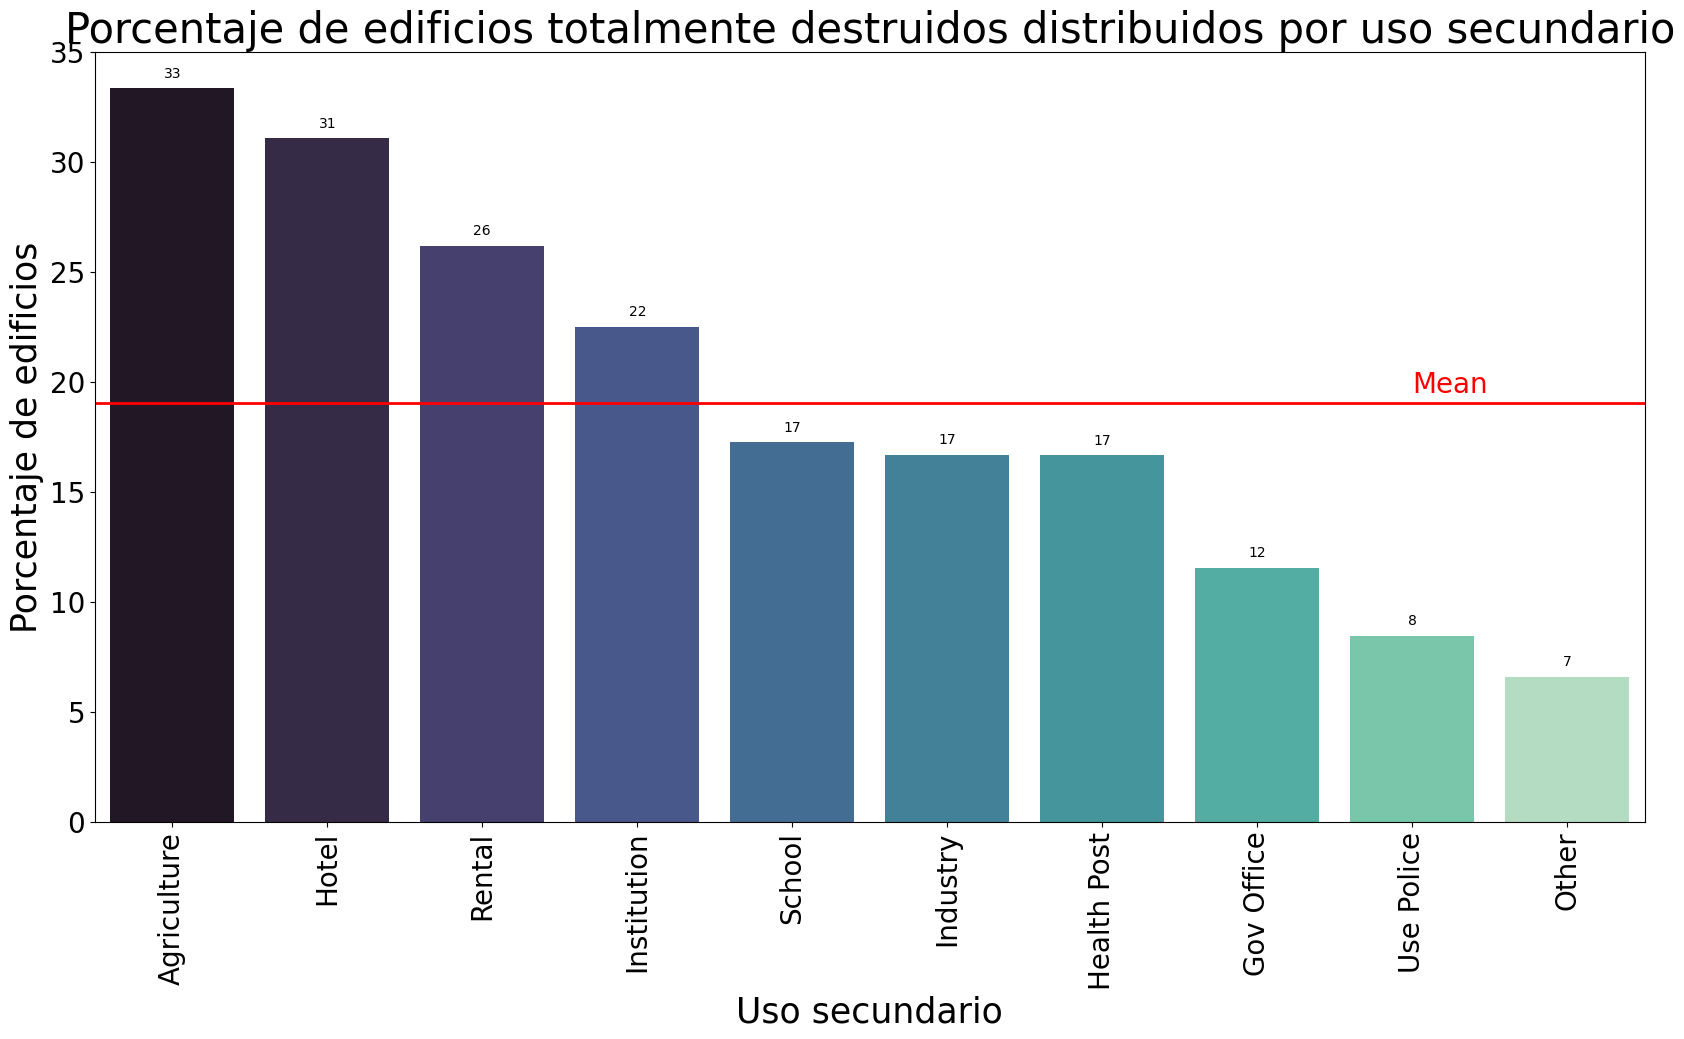

In [115]:
formatted_list = []
for i, secondary in enumerate(list(df_secondary.secondary_use)):
    formatted_string = ' '.join(df_secondary.secondary_use[i].split('_')[3:]).title()
    formatted_list.append(formatted_string)

mean = df_secondary['Complete Destruction'].mean()    
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='secondary_use', y='Complete Destruction', data=df_secondary, 
            palette='mako', ax=ax)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.5,
            '{:1.0f}'.format(height), ha="center")               
ax.axhline(mean, color='red', linewidth=2)            
ax.text(8, mean + 0.5, 'Mean', fontsize=20, color= 'r')            
ax.set_ylabel('Porcentaje de edificios', fontsize=25)
plt.yticks(fontsize=20)
ax.set_xlabel('Uso secundario', fontsize=25)
ax.set_xticklabels(formatted_list, rotation=90, fontsize=20)
ax.set_title('Porcentaje de edificios totalmente destruidos distribuidos por uso secundario', fontsize=30);

Aquí observamos el nivel de daño de destrucción frente al uso secundario que tiene ese edificio.
Vemos que el que tiene mayor porcentaje de destrucción tenía un uso secundario para la agricultura, esto puede deberse a que este tipo de edificios pueden tener un mantenimiento escaso del mismo, conllevando a que sean frágiles a las vibraciones de un terremoto.


Es curioso, que los siguientes edificios sean de uso Hotal o rental. El hotel debería de tener un mantenimiento continuo aunque no se especifica el tipo de hotel, no es lo mismo un hotel que tenga 1 o 2 estrellas a otro que tenga más, pues esto indica que los primeros si deben de tener un mantenimiento más asiduo que el segundo. El de rental, puede ser de particulares que puede a no tener una seguridad un mantenimiento adecuado. 


Con menor destrucción encontramos edificios que se consideran públicos o del gobierno, como puede ser la ofinica gubernamental, los cuales si que cumpliran con los protocolos tanto de construcción como de mantenimiento, además de un mejor material de construcción.
